In [1]:
# Cell 1
import random
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Optional: make behavior repeatable while testing
random.seed(42)


In [2]:
# Cell 2
class HomeEnvironment:
    def __init__(self, rows=2, cols=3, auto_people_prob=0.25):
        self.rows = rows
        self.cols = cols
        self.rooms = {}
        now = datetime.now()
        for r in range(rows):
            for c in range(cols):
                self.rooms[(r,c)] = {
                    'occupancy': False,      # True if person present now
                    'light': 'Off',          # 'On' or 'Off'
                    'last_seen': None        # datetime when motion last observed
                }
        self.time = now
        self.time_step = timedelta(seconds=10)  # each simulation step increments this
        self.auto_people_prob = auto_people_prob

    def step_time(self):
        self.time += self.time_step

    def inject_random_people(self):
        """Toggle occupancy randomly to simulate people moving in/out."""
        for loc in list(self.rooms.keys()):
            if random.random() < self.auto_people_prob:
                # toggle occupancy
                self.rooms[loc]['occupancy'] = not self.rooms[loc]['occupancy']
                if self.rooms[loc]['occupancy']:
                    self.rooms[loc]['last_seen'] = self.time

    def set_occupancy(self, loc, occupied=True):
        self.rooms[loc]['occupancy'] = occupied
        if occupied:
            self.rooms[loc]['last_seen'] = self.time

    def get_percept(self, loc):
        return 'Motion' if self.rooms[loc]['occupancy'] else 'NoMotion'

    def set_light(self, loc, state):
        assert state in ('On', 'Off')
        self.rooms[loc]['light'] = state

    def get_light(self, loc):
        return self.rooms[loc]['light']

    def get_last_seen(self, loc):
        return self.rooms[loc]['last_seen']


In [3]:
# Cell 3
class ModelBasedLightingAgent:
    def __init__(self, rows, cols, hold_time_seconds=60):
        self.rows = rows
        self.cols = cols
        self.hold_time = timedelta(seconds=hold_time_seconds)
        # internal memory: last seen timestamps (None initially)
        self.known_last_seen = {(r,c): None for r in range(rows) for c in range(cols)}

    def update_model(self, loc, percept, current_time):
        if percept == 'Motion':
            self.known_last_seen[loc] = current_time

    def decide(self, loc, percept, current_time):
        # update internal memory
        self.update_model(loc, percept, current_time)

        last = self.known_last_seen[loc]
        if percept == 'Motion':
            return 'TurnOn'
        if last is None:
            # never seen motion here -> keep off
            return 'TurnOff'
        if (current_time - last) <= self.hold_time:
            return 'TurnOn'
        else:
            return 'TurnOff'


In [4]:
# Cell 4
def draw_home(env, step_num=None):
    rows, cols = env.rows, env.cols
    grid = np.zeros((rows, cols))
    for r in range(rows):
        for c in range(cols):
            loc = (r,c)
            occ = env.rooms[loc]['occupancy']
            light = (env.rooms[loc]['light'] == 'On')
            # encoding for color: 0 empty/off, 1 occ/off, 2 empty/on, 3 occ/on
            if occ and not light:
                code = 1
            elif (not occ) and light:
                code = 2
            elif occ and light:
                code = 3
            else:
                code = 0
            grid[r,c] = code

    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#cccccc', '#ff9999', '#fff2a8', '#ffd700'])  # grey, red, light-yellow, yellow
    clear_output(wait=True)
    plt.figure(figsize=(cols*1.8, rows*1.2))
    plt.imshow(grid, cmap=cmap, vmin=0, vmax=3)
    title = f"Smart Lighting | Time {env.time.strftime('%H:%M:%S')}"
    if step_num is not None:
        title += f" | Step {step_num}"
    plt.title(title)
    plt.axis('off')

    # annotate cells
    for r in range(rows):
        for c in range(cols):
            loc = (r,c)
            occ = 'P' if env.rooms[loc]['occupancy'] else '-'
            light = 'On' if env.rooms[loc]['light']=='On' else 'Off'
            last = env.rooms[loc]['last_seen']
            last_str = last.strftime('%H:%M:%S') if last else 'None'
            plt.text(c, r, f"{loc}\nOcc:{occ}\nLight:{light}\nLS:{last_str}",
                     ha='center', va='center', fontsize=8, color='black')
    plt.show()


In [5]:
# Cell 5
def sim_step(env, agent, inject_random=True):
    # optional random people movement
    if inject_random:
        env.inject_random_people()

    # agent decides and environment updates for each room
    for loc in list(env.rooms.keys()):
        percept = env.get_percept(loc)
        action = agent.decide(loc, percept, env.time)  # 'TurnOn' or 'TurnOff'
        if action == 'TurnOn':
            env.set_light(loc, 'On')
            if percept == 'Motion':
                env.rooms[loc]['last_seen'] = env.time  # sensor updates env memory too
        else:
            env.set_light(loc, 'Off')

    # advance the simulated clock
    env.step_time()


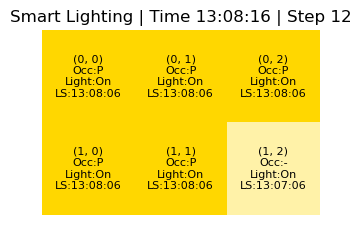

Demo finished.


In [6]:
# Cell 6
def run_demo(steps=12, rows=2, cols=3, hold_seconds=60, inject_prob=0.25, delay=0.6):
    env = HomeEnvironment(rows=rows, cols=cols, auto_people_prob=inject_prob)
    agent = ModelBasedLightingAgent(rows=rows, cols=cols, hold_time_seconds=hold_seconds)
    for s in range(1, steps+1):
        sim_step(env, agent, inject_random=True)
        draw_home(env, step_num=s)
        time.sleep(delay)
    print("Demo finished.")

# Example: run demo now
run_demo(steps=12, rows=2, cols=3, hold_seconds=60, inject_prob=0.25, delay=0.6)
